In [1]:
# Patrick Daly
# UMN Kaggle 
# July 2, 2015
#
# Titanic Data Set
# - Machine Learning From Disaster
# 
# July 2, 2015 - Basic modeling, just getting up and running with python
# 

# Default BoilerPlate libs
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

# Popular modeling libraries
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
# you need to install this via git
# create some folder and call it python packages or something, these
# will be libraries you build using "make". After you create the library
# $ cd nameoflibrary
# $ git clone https://github.com/dmlc/xgboost
# $ cd xgboost
# $ make
# $ cd wrapper
# $ sudo python setup.py install
# now xgboost should be installed
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

# Plotting setttings
%matplotlib inline
import matplotlib.pyplot as plt

# R style plotting
# install this from git by typing the following
# pip install git+git://github.com/yhat/ggplot.git
from ggplot import *

# Better looking plotting
import seaborn as sns
sns.set_palette("deep", desat = 0.6)
sns.set_context(rc={"figure.figsize": (8,4)})

# Suppress unnecessary errors
import warnings
warnings.filterwarnings('ignore')

# Categorical variable descriptives
def categorical_describe(df):
    return df[df.columns[df.dtypes == 'object']].describe()

# Create dummy vars for all categoricals
def build_dummies(df):
    categoricals = list( df.columns[ df.dtypes == 'object' ])
    for variable in categoricals:
        dummies = pd.get_dummies(df[variable])
        df = pd.concat( [df, dummies], axis=1)
        df.drop(variable, axis=1, inplace=True)
    return df


# 5 fold cross validation, return the mean of the model scores
def cv_score(model, df):
    X = df.drop('Survived', axis=1)
    y = df['Survived']
    scores = []
    for _ in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
        model.fit(X_train, y_train)
        scores.append(model.score(X_test,y_test))
    return np.mean(scores)

train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

# ...Figure out how to format this output later
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

In [28]:
train.shape

(891, 11)

In [29]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [30]:
# ~180 missing age values, ~700 missing cabin values and a few missing Embarked values
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [31]:
# Numerical variable descriptives
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [32]:
categorical_describe(train)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


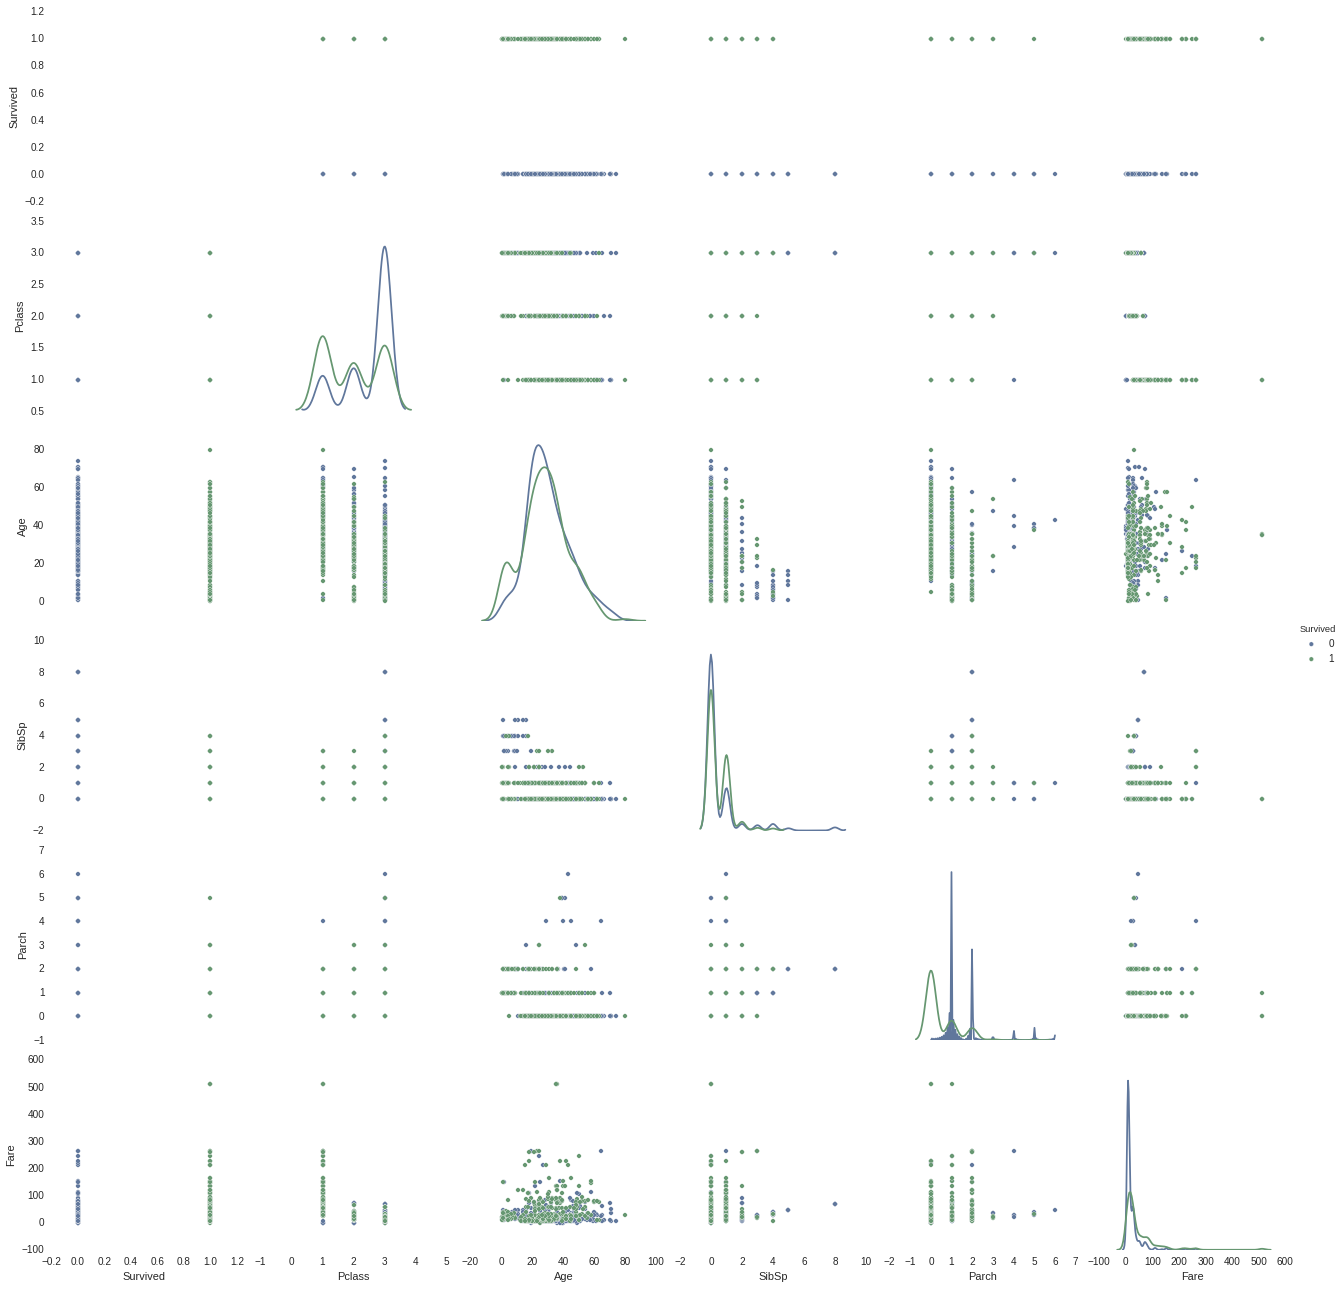

In [58]:
sns.pairplot( train, diag_kind = 'kde', hue='Survived');

In [ ]:
tr = train.dropna().copy()
fig, axs = plt.subplots(4,2, figsize=(15,10))
fig.tight_layout()
sns.distplot(tr['Survived'], ax=axs[0][0]);
sns.distplot(tr['Pclass'], ax=axs[0][1]);
sns.distplot(tr['Age'], ax=axs[1][0]);
sns.distplot(tr['SibSp'], ax=axs[1][1]);
sns.distplot(tr['Parch'], ax=axs[2][0]);
sns.distplot(tr['Fare'], ax=axs[2][1]);
sns.barplot(tr['Sex'], ax=axs[3][0], color = ['grey', 'red']);
sns.barplot(tr['Embarked'], ax=axs[3][1], color = ['grey', 'grey', 'red']);

In [2]:
# Clean up the vars
train_clean = train.copy()

# Combine SibSp and Parch to create a new feature FamilySize
train_clean['FamilySize'] = train_clean['SibSp'] + train_clean['Parch'] + 1

# Combine last name + family size to unique identify a family
train_clean['Family'] = train_clean['Name'].apply(lambda name: name.split(',')[0]) + \
                        train_clean['FamilySize'].apply(lambda size: str(size))

# Title - deal with this later, sounds like regex...

# set some dummy vars for categorical data or use build_dummies
# train_clean['Sex'] = train_clean['Sex'].map( {'male':1, 'female':0} ).astype(int)

# only 2 w/o departing values, impute the most frequent, 'S'
# train_clean['Embarked'].fillna(value=train_clean['Embarked'].mode()[0], inplace=True)

# drop ticket, name and cabin for now, maybe incorporate them later
train_clean.drop(['Ticket', 'Cabin', 'Embarked', 'Name'], axis=1, inplace=True)

# get them dummies!
train_clean = build_dummies(train_clean)

In [3]:
train_clean.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,female,male,Abbing1,...,Yousseff1,Yrois1,Zabour2,Zimmerman1,de Messemaeker2,de Mulder1,de Pelsmaeker1,del Carlo2,van Billiard3,van Melkebeke1
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,22,1,0,7.2500,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,38,1,0,71.2833,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,26,0,0,7.9250,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,35,1,0,53.1000,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,3,35,0,0,8.0500,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# fill in sex using a linear model (do not use survived as a predictor)
train_age_model = train_clean.dropna().copy()
y = train_age_model['Age']
X = train_age_model.drop(['Age', 'Survived'], axis=1)
age_ols = sm.OLS(y,X)
age_ols_fit = age_ols.fit()
print age_ols_fit.summary()

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     8.756
Date:                Sun, 19 Jul 2015   Prob (F-statistic):           2.53e-40
Time:                        17:14:46   Log-Likelihood:                -2246.9
No. Observations:                 714   AIC:                             5626.
Df Residuals:                     148   BIC:                             8213.
Df Model:                         566                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Pclass                     -9.1771      5.128     -1.790      0.076       -19.310     0.956
SibSp        

In [5]:
# good enough for now
#
# this next part can be done cleaner... but it works
# get the dataframe where Age is NaN and drop that column so we have the predictors associated with the
#   NaN age values
train_age_missing = train_clean[train_clean['Age'].isnull()]
train_age_missing.drop(['Age','Survived'], axis=1, inplace=True)
# replace missing Age vals with the predicted vals
train_clean['Age'][train_clean['Age'].isnull()] = age_ols_fit.predict(train_age_missing)

# Model sandbox
### Most are out of the box, a few I've added a minor change or two. Do a parameter sweep, plot the results and optimize the models. Lots to do here but this is a start. Type "shift + tab"  w/in the parenthesis to see what options are avaible to each model or check online.

In [ ]:
# Hill Climbing / Grid Search - overfit the shit outta everything!
# from sklearn.grid_search import GridSearchCV
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# clf = GridSearchCV( LogisticRegression(), param_grid)
# clf.fit(X,y)
# clf.grid_scores_
#
# place w/e the model is for LogisticRegression and any number of parameters in the param_grid dictionary,
#   the algorithm will just run the fit over and over with different values of the parameter and spit back
#   the results. One clear use for this is sweeping across 'n_estimators' values which is found in most models.

In [6]:
# 1. Logistic Regression - > Benchmark
logit = LogisticRegression()
logit_scores = cv_score(logit, train_clean)
logit_scores

0.50726256983240225

In [7]:
# 2. Random Forest Classification
rf = RandomForestClassifier(n_estimators=100)
rf_scores = cv_score(rf, train_clean)
rf_scores

0.82346368715083806

In [8]:
# 3. AdaBoost Classification
ada = AdaBoostClassifier()
ada_scores = cv_score(ada, train_clean)
ada_scores

0.8134078212290502

In [9]:
# 4. Gradient Boosting Classification
gbc = GradientBoostingClassifier()
gbc_scores = cv_score(gbc, train_clean)
gbc_scores

0.79217877094972067

In [10]:
# 5. XGBoost (Extreme Gradient Boosting) Classification
xgb = XGBClassifier()
xgb_scores = cv_score(xgb, train_clean)
xgb_scores

0.82011173184357544

In [ ]:
# 6. Support Vector Machine Classification
svm = SVC(kernel='linear')
svm_scores = cv_score(svm, train_clean)
svm_scores

In [11]:
# 7. Gaussian Naive Bayes
gnb = GaussianNB()
gnb_scores = cv_score(gnb, train_clean)
gnb_scores

0.49832402234636869

In [12]:
# 8. Multinomial Naive Bayes
#   odd error with this one, fix later
mnb = MultinomialNB()
mnb_scores = cv_score(mnb, train_clean)
mnb_scores

ValueError: Input X must be non-negative

In [13]:
# 9. Bernouli Naive Bayes
bnb = BernoulliNB()
bnb_scores = cv_score(bnb, train_clean)
bnb_scores

0.7932960893854748

In [14]:
# 10. Perceptron
ptron = Perceptron(n_iter=1000)
ptron_scores = cv_score(ptron, train_clean)
ptron_scores

0.50055865921787712

In [15]:
# 11. Stochastic Gradient Descent
sgd = SGDClassifier(loss='modified_huber', n_iter=500)
sgd_scores = cv_score(sgd, train_clean)
sgd_scores

0.50949720670391063

In [ ]:
# Roc benchmark curves
X = train_clean.drop('Survived', axis=1)
y = train_clean['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

clfs = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest Classification', RandomForestClassifier(n_estimators=100)),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('SVM', SVC(probability=True, kernel='linear')),
    ('Gaussian Naive Bayes', GaussianNB()),
    #('Multinomial Naive Bayes', MultinomialNB()), # odd negative error prevents this from learning
    ('Bernoulli Naive Bayes', BernoulliNB()),
    #('Perceptron', Perceptron(n_iter=100)), # no predict_proba method for some reason
    ('SGD', SGDClassifier(loss='modified_huber', n_iter=500))
]
all_results = None
for name, clf in clfs:
    clf.fit(X_train.to_dense(), y_train)
    probs = clf.predict_proba(X_test.to_dense())[:,1]
    fpr, tpr, thresh = roc_curve(y_test, probs)
    results = DataFrame({
            'name': name,
            'fpr': fpr,
            'tpr': tpr
        })
    if all_results is None:
        all_results = results
    else:
        all_results = all_results.append(results)

ggplot(aes(x='fpr', y='tpr', color='name'), data=all_results) + \
    geom_step() + \
    geom_abline(color='black') + \
    ggtitle('Fit Benchmarking')

In [ ]:
# Experimenting with line visualization... update later
ggplot(aes(x='fpr', y='tpr', color='name'), data=all_results) + \
    geom_line() + \
    geom_abline(color='black') + \
    ggtitle('Fit Benchmarking')